In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')
sns.set_context("talk")

In [6]:
epoch_key = ('chimi', 5, 2) # animal, day, epoch

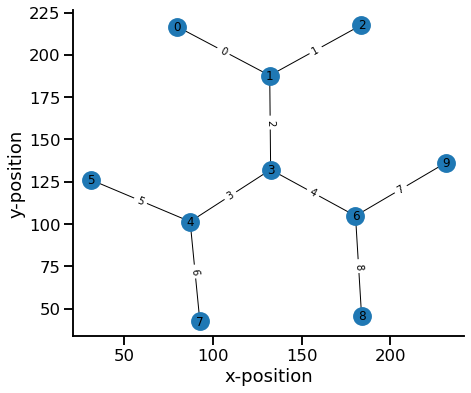

In [13]:
from src.load_data import get_track_graph
from track_linearization import plot_track_graph


track_graph = get_track_graph()

fig, ax = plt.subplots(figsize=(7, 6))
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

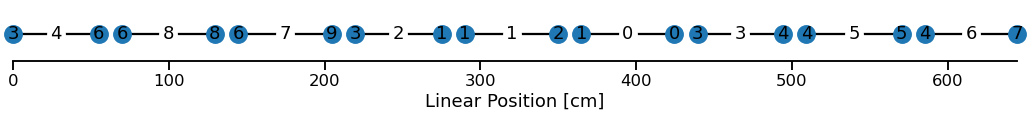

In [24]:
from track_linearization.utils import plot_graph_as_1D
from src.parameters import (EDGE_ORDER, EDGE_SPACING)

fig, ax = plt.subplots(figsize=(18, 1))
plot_graph_as_1D(track_graph,
                 edge_spacing=EDGE_SPACING,
                 edge_order=EDGE_ORDER,
                 ax=ax,
                 draw_edge_labels=True,
                )

In [82]:
from src.load_data import load_data


data = load_data(epoch_key)

13-Jan-21 19:26:24 Loading position information and linearizing...
13-Jan-21 19:26:28 Loading multiunits...
13-Jan-21 19:26:41 Loading theta...


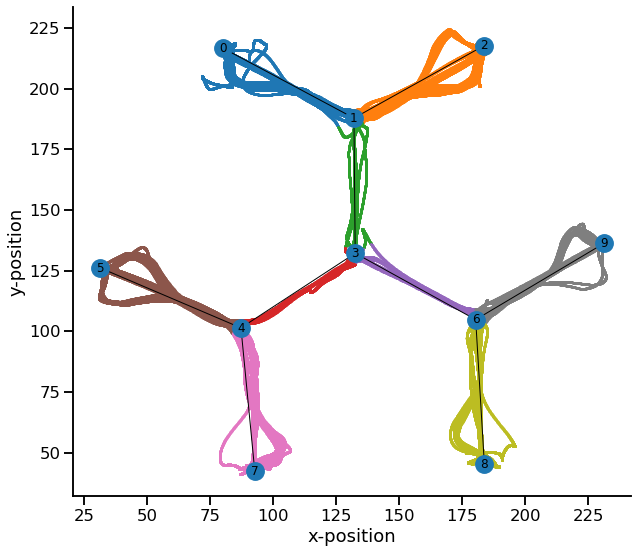

In [104]:
fig, ax = plt.subplots(figsize=(10, 9))
plot_track_graph(data['track_graph'], ax=ax, draw_edge_labels=False)
for name, df in data['position_info'].groupby('track_segment_id'):
    plt.scatter(df.x_position, df.y_position, s=1, label=name,
                zorder=-1)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

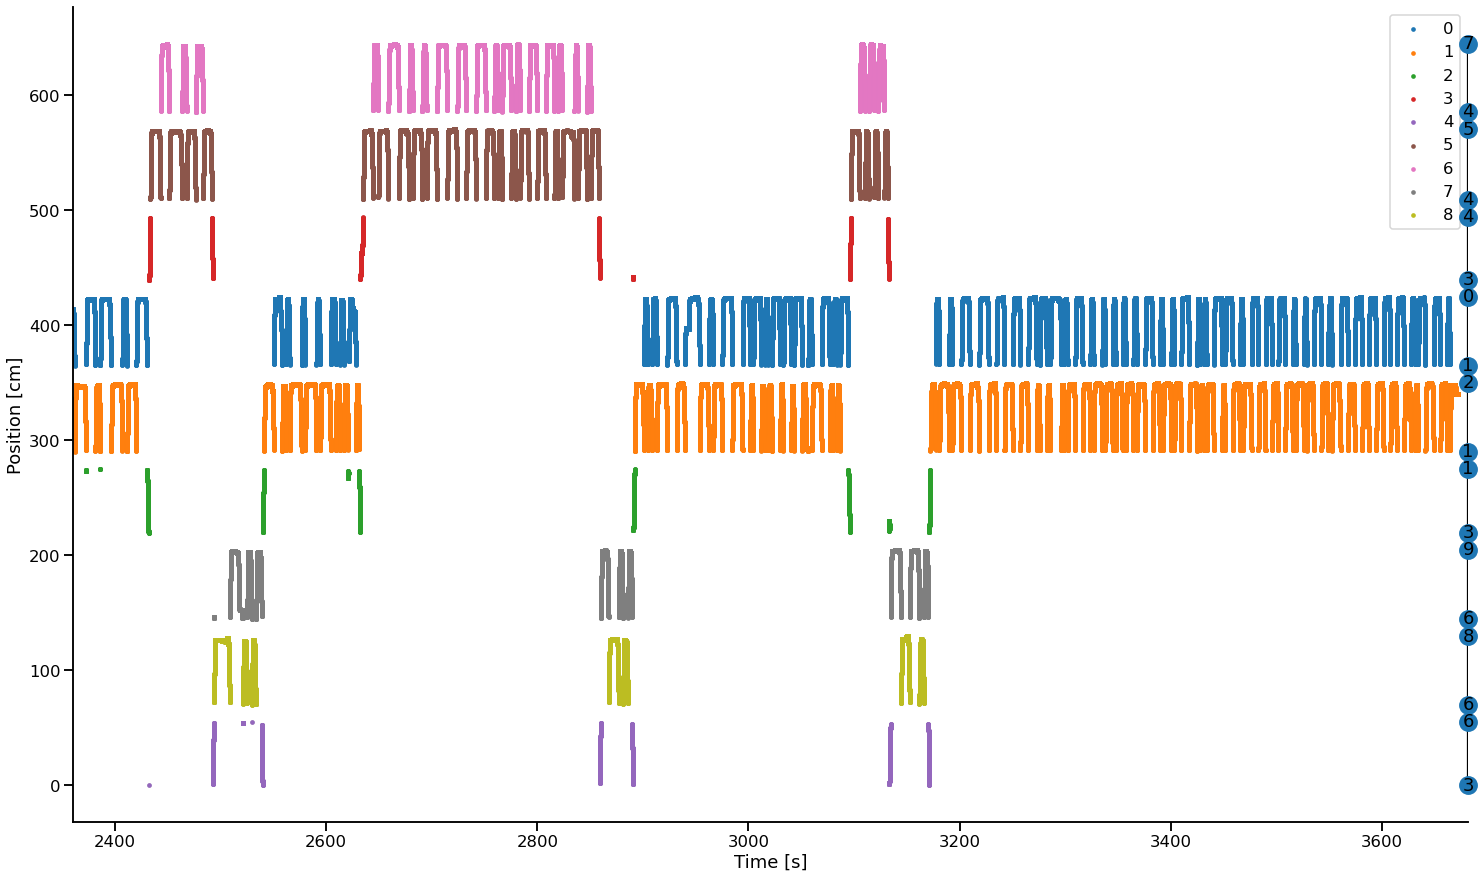

In [97]:
from track_linearization import plot_graph_as_1D
from src.parameters import EDGE_ORDER, EDGE_SPACING

plt.figure(figsize=(25, 15))

time = data['position_info'].index / np.timedelta64(1, 's')
plt.scatter(time,
            data['position_info'].linear_position, color='lightgrey', s=10)

for name, df in data['position_info'].groupby('track_segment_id'):
    plt.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=10, label=name)

plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=10.0 + time[-1])

plt.legend()
plt.ylabel('Position [cm]')
plt.xlabel('Time [s]')
plt.xlim((time[0], time[-1] + 10.0))

sns.despine()

In [105]:
continuous_transition_types = (
    [['random_walk', 'uniform'],
     ['uniform',     'uniform']])


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])}, 
}

In [ ]:
from replay_trajectory_classification import ClusterlessClassifier
from sklearn.model_selection import KFold

state_names = ['Continuous', 'Fragmented']
cv = KFold()
results = []

for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    classifier = ClusterlessClassifier(**classifier_parameters)
    classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunits"].isel(time=train),
        track_graph=data["track_graph"],
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )

    logging.info('Predicting posterior...')
    results.append(
        classifier.predict(
            data["multiunits"].isel(time=test),
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
            state_names=state_names
        )
    )
    
# concatenate cv classifier results 
results = xr.concat(results, dim="time")
logging.info('Done...\n\n')

13-Jan-21 19:58:07 Fitting Fold #1...
13-Jan-21 19:58:07 Fitting initial conditions...
13-Jan-21 19:58:08 Fitting state transition...
13-Jan-21 19:58:08 Fitting multiunits...
13-Jan-21 19:58:15 Predicting posterior...


In [ ]:
classifier.save_model(f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_model.pkl")

In [ ]:
results.to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_results.nc"
)

In [ ]:
results

In [ ]:
from trajectory_analysis_tools import (get_ahead_behind_distance,
                                       get_trajectory_data)

posterior = results.acausal_posterior.sum("state")

trajectory_data = get_trajectory_data(
    posterior,
    data['track_graph'],
    classifier,
    data['position_info'])

ahead_behind_distance = get_ahead_behind_distance(
    data['track_graph'], *trajectory_data)

In [ ]:
from trajectory_analysis_tools import get_highest_posterior_threshold, get_HPD_spatial_coverage

hpd_threshold = get_highest_posterior_threshold(posterior, coverage=0.95)
spatial_coverage = get_HPD_spatial_coverage(posterior, hpd_threshold)